In [2]:
%load_ext autoreload
%autoreload 2

from joblib import Parallel, delayed
import multiprocessing

from tqdm import tqdm, tqdm_notebook
from IPython.display import display
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pickle
import os
import sys
sys.path.append('../..')
from helper.orderbook_trader import OrderbookTradingSimulator
from helper.manage_orderbooks import *
from helper.evaluation import evaluate, plot_evaluation_costs
from helper.general_helpers import add_features_to_orderbooks, load_and_preprocess_historyfiles, discretize_hist_feature

from agents.RL_Agent_Base import RLAgent_Base
from agents.BatchTree_Agent import RLAgent_BatchTree
from agents.QTable_Agent import QTable_Agent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load pretrained Agents

In [15]:
agent_files = [
    '../trainedAgents/longterm_1611_1704_currBid/QTable_1611-1704_T4_I8_VolTime.json',
    # '../trainedAgents/longterm_1611_1704_currAsk/QTable_1611-1704_T4_I8_VolTime.json',
    '../trainedAgents/longterm_1611_1704/QTable_1611-1704_T4_I8_VolTime.json'
]

print(agent_files)

['../trainedAgents/longterm_1611_1704_currBid/QTable_1611-1704_T4_I8_VolTime.json', '../trainedAgents/longterm_1611_1704/QTable_1611-1704_T4_I8_VolTime.json']


QTable_1611-1704_T4_I8_VolTime0


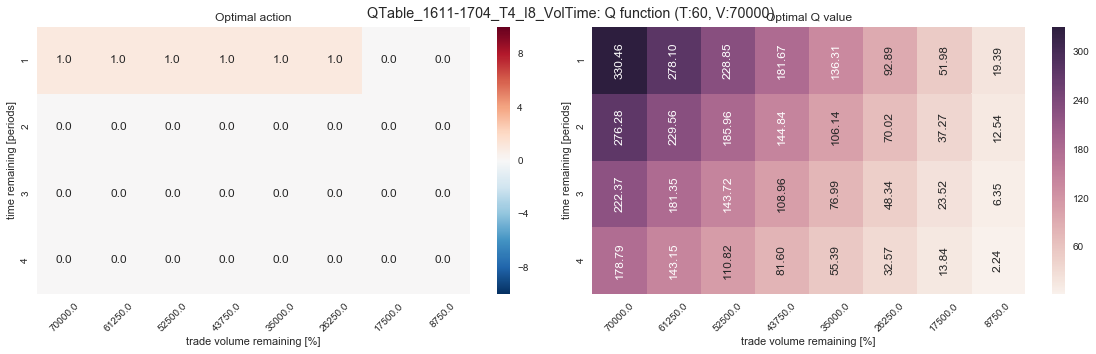

RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>, Name: 'QTable_1611-1704_T4_I8_VolTime', state_variables: '['volume', 'time']'
QTable_1611-1704_T4_I8_VolTime1


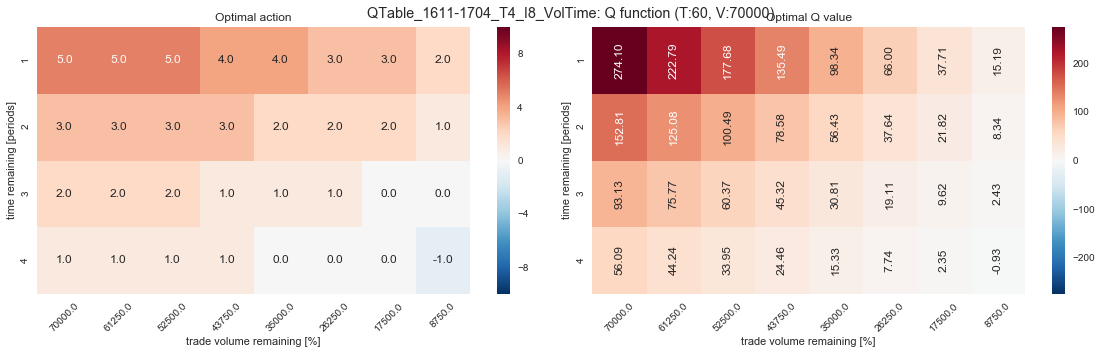

RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>, Name: 'QTable_1611-1704_T4_I8_VolTime', state_variables: '['volume', 'time']'
agent_collection contains 2 elements:
['QTable_1611-1704_T4_I8_VolTime0', 'QTable_1611-1704_T4_I8_VolTime1']


In [27]:
agent_collection = {}
try:
    agent_collection
except NameError:
    agent_collection = {}
    
for e, elem in enumerate(agent_files):
    folder, name = os.path.split(elem)
    
    name = name[:-5]
    print(name+str(e))
    agent = RLAgent_Base.load(agent_name=name, path=folder, ignore_samples=False)
    agent.heatmap_Q()
    print(agent)
    agent_collection[name+str(e)] = agent
    
print("agent_collection contains {} elements:\n{}".format(len(agent_collection), list(agent_collection.keys())))


In [29]:
agent_collection['QTable_1611-1704_T4_I8_VolTime0'].samples.head(20)

,volume,time,action,action_idx,cost,avg,initial_center,timestamp,volume_n,time_n
0,70000.0,1.0,-4.0,0,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
1,70000.0,1.0,-3.0,1,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
2,70000.0,1.0,-2.0,2,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
3,70000.0,1.0,-1.0,3,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
4,70000.0,1.0,0.0,4,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
5,70000.0,1.0,1.0,5,178.630662,707.02972,705.225474,2016-11-08 10:45:00,0.0,0.0
6,70000.0,1.0,2.0,6,666.726197,712.00710,705.225474,2016-11-08 10:45:00,0.0,0.0
7,70000.0,1.0,3.0,7,666.726197,712.00710,705.225474,2016-11-08 10:45:00,0.0,0.0
8,70000.0,1.0,4.0,8,666.726197,712.00710,705.225474,2016-11-08 10:45:00,0.0,0.0
9,70000.0,1.0,5.0,9,666.726197,712.00710,705.225474,2016-11-08 10:45:00,0.0,0.0


In [30]:
agent_collection['QTable_1611-1704_T4_I8_VolTime1'].samples.head(20)

,volume,time,action,action_idx,cost,avg,initial_center,timestamp,volume_n,time_n
0,70000.0,1.0,-4.0,0,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
1,70000.0,1.0,-3.0,1,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
2,70000.0,1.0,-2.0,2,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
3,70000.0,1.0,-1.0,3,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
4,70000.0,1.0,0.0,4,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
5,70000.0,1.0,1.0,5,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
6,70000.0,1.0,2.0,6,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
7,70000.0,1.0,3.0,7,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
8,70000.0,1.0,4.0,8,645.397921,711.78814,705.225474,2016-11-08 10:45:00,0.0,0.0
9,70000.0,1.0,5.0,9,96.607868,706.20011,705.225474,2016-11-08 10:45:00,0.0,0.0


In [ ]:
# source_agent = agent_collection['QTable_1612-1702_T4_I8']
# print("Samples:", source_agent.samples.shape)
# tet = source_agent.convert_to_BatchTreeAgent(new_name="te", train=True)
# print(tet)
# print(source_agent.state_variables)
# agent_collection = {
#     'source_agent': source_agent,
#     'converted_agent': tet
# }

In [ ]:
agent_direction = agent_collection['converted_agent']
for d in [-2., -1., 0., 1., 2.]:
    agent_direction.heatmap_Q(extra_variables={'direction_disc': d})

In [ ]:
agent_direction = agent_collection['QTable_1612-1702_T4_I8_marketPrice_spread']
for d in [0., 1., 2., 3., 4.]:
    agent_direction.heatmap_Q(extra_variables={'marketPrice_spread_disc': d})

### Load data

In [ ]:
# histfiles = [
#     "../../../../data/history/history_2016-11_USDT_BTC.csv",
#     "../../../../data/history/history_2016-12_USDT_BTC.csv",
#     "../../../../data/history/history_2017-01_USDT_BTC.csv",
#     "../../../../data/history/history_2017-02_USDT_BTC.csv",
# ]
# 
# hist = load_and_preprocess_historyfiles(histfiles)
# 
# hist['future15_disc'] = pd.cut(hist.future15, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
# hist['future30_disc'] = pd.cut(hist.future30, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
# hist['future45_disc'] = pd.cut(hist.future45, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
# hist['spread_disc'] = pd.cut(hist.spread, bins=[0, 1, 2, np.inf], labels=False)
# # display(hist.iloc[1021:1025,:])

In [ ]:
variables = []
for ag in agent_collection.values():
    print(ag.agent_name, ag.state_variables)
    variables += ag.state_variables
variables = set(variables)
variables.remove('time')
variables.remove('volume')
#variables = [v[:-5] for v in variables]
variables

In [ ]:
hist = pd.read_csv('ob_features70000_1611_1705.csv', index_col=0, parse_dates=[0])
variables_disc = [v[:-5] for v in variables if v.endswith('_disc')]

for feat in variables_disc:
    print('discretize', feat)
    hist = discretize_hist_feature(hist, feature=feat, test_start_date='2017-03-01', bins=3)
display(hist.head(3))

In [ ]:
data_mini = pickle.load( open( "cached_windows/tradingwindows_1611_USTD_BTC_20.p", "rb" ) )
num_cores = multiprocessing.cpu_count()
data_mini = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(orderbooks=window, hist=hist,
                                                                                      features=variables) 
                                                 for window in data_mini[:])
print(len(data_mini), len(data_mini[0]))
data = data_mini

In [ ]:
data_nov = pickle.load( open( '../cached_windows_60mins/obs_2016-11_USDT_BTC_maxVol100.p', "rb" ) )
print(len(data_nov))
print(data_nov[0][0])
num_cores = multiprocessing.cpu_count()
data_nov = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(
    orderbooks=window, 
    hist=hist,
    features=variables) 
                                                  for window in data_nov[:192])
print(len(data_nov))
data_nov[0][0]

In [ ]:
data_dec = pickle.load( open( '../cached_windows_60mins/obs_2016-12_USDT_BTC_maxVol100.p', "rb" ) )
print(len(data_dec))
print(data_dec[0][0])
num_cores = multiprocessing.cpu_count()
data_dec = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(
    orderbooks=window, 
    hist=hist,
    features=["{}_disc".format(v) for v in variables]) 
                                                 for window in data_dec[:192])
print(len(data_dec))
data_dec[0][0]

In [ ]:
pickle.dump( data_mar, open( '../cached_windows_60mins_V200/obs_2017-03_USDT_BTC_maxVol200.p', "wb" ) )

In [ ]:
data_mar = pickle.load( open( '../cached_windows_60mins_V200/obs_2017-03_USDT_BTC_maxVol200.p', "rb" ) )
print(len(data_mar))
print(data_mar[0][0])
# num_cores = multiprocessing.cpu_count()
# data_mar = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(
#     orderbooks=window, 
#     hist=hist,
#     features=["{}_disc".format(v) for v in variables]) 
#                                                  for window in data_mar)
# data_mar[0][0]

### Evaluate

In [ ]:
data = data_nov[:24]
baseline = 'test_Dec24_VolTime'
# baseline = list(agent_collection.keys())[0]
costs, slippage = evaluate(
    testdata=data,
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[5, 'MarketOrder'],
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.describe())
plot_evaluation_costs(slippage, hline=baseline, showfliers=False)

In [ ]:
slippage.mean()

In [ ]:
plot_evaluation_costs(costs, hline=baseline, showfliers=False, ylim=(100,300))

In [ ]:
data = data_nov[:]
costs = None
baseline = 'QTable_1612-1702_T4_I8_VolTime'
# baseline = list(agent_collection.keys())[0]
costs, slippage = evaluate(
    testdata=data,
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[5],
    costs=costs,
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.describe())
plot_evaluation_costs(slippage, hline=baseline, showfliers=False)

In [ ]:
data = data_dec[:96]
costs = None
baseline = 'QTable_1612-1702_T4_I8'
costs, slippage = evaluate(
    testdata=data,
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[5],
    costs=costs,
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.describe())
plot_evaluation_costs(slippage, hline=baseline)

In [ ]:
slippage

In [ ]:
plot_episode(data_dec[62], limits=[765.527563, 767.819562, 769.347561, 770.875560], consume='volume', volume=100)
#plot_episode(data_dec[62], limits=[765.527563, 767.819562, 769.347561, 770.875560], consume='cash', volume=70000)

In [ ]:
start = 0
end = 100

print(slippage.shape)
slippage.iloc[start:end,:].plot(figsize=(12,8))
plt.plot(slippage.iloc[start:end,:].mean(axis=1).values, color='black', linestyle='--')

tmp = slippage.subtract(slippage.mean(axis=1).values, axis=0)
tmp.iloc[start:end,:].plot(figsize=(12,8))
plt.plot(tmp.iloc[start:end,:].mean(axis=1).values, color='black', linestyle='--')

In [ ]:
name = '1611-1701_USDTBTC_Qtable_100vol10_60T4'

modelpath = os.path.join("../Runs/evaluation/models/{}.json".format(name))
ql = QLearn.load(infile=modelpath)
ql.plot_Q(z_represents="action")
ql.plot_Q(z_represents="Q")
ql.heatmap_Q()

In [ ]:
ql = QLearn.load(infile=modelpath)

T = ql.T
V = ql.V
period_length = ql.period_length
actions = ql.actions

filename_train = '/home/axel/data/obs_2016-12_USDT_BTC_range1.2.dict'
filename_test = '/home/axel/data/obs_2017-02_USDT_BTC_range1.2.dict'

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*period_length)
print("Length of episodes_train: {}".format(len(episodes_train)))

episodes_test = OrderbookEpisodesGenerator(filename=filename_test, episode_length=T*period_length)
print("Length of episodes_test: {}".format(len(episodes_test)))

In [ ]:
def plot_experiment_results(experiments, name=None, ylim=None, showfliers=False, hline=None):
    assert isinstance(hline, str) or hline is None
    
    experiments.plot.box(showmeans=True, color={'medians':'green'}, figsize=(12, 8), showfliers=showfliers)

    plt.axvline(2.5, color='black')
    plt.axvline(3.5, color='black')
    plt.axhline(0, color='black')
    
    if hline is not None:
        plt.axhline(experiments[hline].mean(), color='red', alpha=0.5, linewidth=2, linestyle='--', label='min mean')
        plt.axhline(experiments[hline].median(), color='green', alpha=0.5, linewidth=2, linestyle='--', label='min median')
    
    title = "{} samples  \n{} - {}".format(len(experiments), experiments.index[0], experiments.index[-1])
    if name is not None:
        title = "{}: {}".format(name, title)
    print(title)
    #plt.suptitle(title)
    plt.xlabel("Strategies")
    plt.ylabel("Occured costs")
    plt.savefig("boxplot_train.pdf")
    plt.xticks(rotation=70)
    if ylim is not None:
        plt.ylim(ylim)    
    plt.legend(loc='best')
    
    plt.show()

In [ ]:
def run_Q(V, H, T, ql, episode_windows, actions, costs=None):
    costs = pd.DataFrame([])
    period_length = int(H/T)

    for e, episode in tqdm(enumerate(episode_windows)):
        index = episode[0].timestamp
        
        volume = V
        
        ## Learned strategy
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=T,
                                         period_length=period_length)
        for tt in range(1, T+1, 1)[::-1]:
            new_vol = round_custombase(ots.volume, base=ql.vol_intervals)  
        
            if new_vol > 0:
                idx = (T-tt)*period_length
                state = ql.state_as_string(time_left=tt, volume_left=new_vol/V)
                # print(idx, state)
                action = ql.chooseAction(state)
        
                # print(state, action)
                obs = episode[period_length * (T-tt)].copy()
                # obs = [elem.copy() for elem in obs_]
            
                ask = obs.get_ask()
                # center = ots.masterbook.get_center()
                limit = ask * (1. + (action/100.))
            else:
                # theoreticall done
                limit == None
            ots.trade(limit = limit, extrainfo={'ACTION':action})
        costs.loc[index, 'Learned_1611-1701'] = ots.history.cost.sum()

    
        ## market order
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=T,
                                        period_length=period_length)
        ots.trade(limit = None)
        costs.loc[index, 'Market'] = ots.history.cost.sum()
        
        # for a in actions:
        a = 0.4
        lim = episode[0].get_ask() * (1. + (a/100.))
        # print("\n### Fixed limit at: {} (ASK+4) ###".format(lim))
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=1,
                                        period_length=period_length*T)
        ots.trade(limit = lim)
        key = 'ask*{:1.3f}'.format((1. + (a/100.)))
        costs.loc[index, key] = ots.history.cost.sum()

        
        if e%5==0 or e==len(episode_windows)-1:
            display.clear_output(wait=True)
            plot_experiment_results(costs, name='Testset (USDT-BTC, Feb 2017):')
            
            # costs.to_csv("../Runs/evaluation/Evaluation_obs_TESTSET_2016-12_USDT_BTC_LEARNED_.csv")
            mean = costs.mean()
            print(mean)
            print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))
        
    return costs

## Check for best S&L Strategy over training data (Nov16-Jan17)

In [ ]:
costs_list_train = pd.concat([
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2016-11_USDT_BTC.csv", index_col=0),
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2016-12_USDT_BTC.csv", index_col=0),
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2017-01_USDT_BTC.csv", index_col=0)])

plot_experiment_results(costs_list_train, name='Trainset (USDT-BTC)', ylim=(-1.5, 1.5))

mean = costs_list_train.mean()
print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))

### Compare strategies on Testset (Feb2017)

In [ ]:
T = ql.T
V = ql.V
period_length = ql.period_length
print("V={}, T={}, period_length={}".format(V, T, period_length))

costs_list = run_Q(V=100, H=T*period_length, T=T, ql=ql,
                   episode_windows=episodes_test[:5], actions=actions)

In [ ]:
plot_experiment_results(costs_list, name='Trainset (USDT-BTC)')  #, ylim=(-1.5, 1.5))
mean = costs_list_train.mean()
print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))